In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
pdb = 'structures/alanine_beta.pdb'
#Protein coordinates
XYZ = np.genfromtxt(pdb)[:,5:8]
#Selection coordinates
l = np.genfromtxt(pdb)[[0,5],:][:,5:8]
m = np.genfromtxt(pdb)[[1,6,4,7,8,9,2,3],:][:,5:8]
n = np.genfromtxt(pdb)[[10,11,14,15,16,17,18,19],:][:,5:8]
o = np.genfromtxt(pdb)[[12,13,20,25],:][:,5:8]
p = np.genfromtxt(pdb)[[21,22,23,24,26,27,28,29],:][:,5:8]
selec = [l, m, n, o, p]

In [3]:
class Node:    
    
    """Constructor to create a new node"""
    
    def __init__(self, obb, parents, children):
        self.obb = obb 
        self.parents = parents
        self.children = children
        
    def __str__(self):
        return '%s    %s    %s' % (self.obb, self.parents, self.children)
        
    def Vertex_OBB(XYZ):
        """
        Computes the 8 vertex of the Oriented Bounding Box
        -----------
        Arguments:
        -----------
        XYZ : array of shape (n,3). Contains the coordinates of
              the atoms to be enclosed by the OBB.        
        """
        
        # Compute scatter matrix
        scat = XYZ.T @ XYZ
        # Compute singular values or eigenvalues
        eigen_vecs, _, _ = np.linalg.svd(scat)
        #_, eigen_vecs = np.linalg.eig(scat)

        # project XY onto the "principal axes"
        XYZ_proj = XYZ @ eigen_vecs

        # compute min/max values (or whatever you need)
        min_x, min_y, min_z = np.min(XYZ_proj, 0)
        max_x, max_y, max_z = np.max(XYZ_proj, 0)

        #S radius
        Sr = 1.85

        ver_proj_S = np.array([[min_x - Sr, min_y - Sr, min_z - Sr],#
                         [min_x - Sr, max_y + Sr, min_z - Sr],#
                         [max_x + Sr, min_y - Sr, min_z - Sr],
                         [max_x + Sr, max_y + Sr, min_z - Sr],
                         [min_x - Sr, min_y - Sr, max_z + Sr],#
                         [min_x - Sr, max_y + Sr, max_z + Sr],#
                         [max_x + Sr, min_y - Sr, max_z + Sr],
                         [max_x + Sr, max_y + Sr, max_z + Sr]])
        
        ver_proj = np.array([[min_x , min_y , min_z ],#
                         [min_x, max_y, min_z ],#
                         [max_x, min_y, min_z ],
                         [max_x, max_y, min_z],
                         [min_x, min_y, max_z],#
                         [min_x, max_y, max_z],#
                         [max_x, min_y, max_z],
                         [max_x, max_y, max_z]])

        # project min/max values back to the original system
        vertex = ver_proj_S @ eigen_vecs.T
        #ver = ver_proj @ eigen_vecs.T # use this with eigenvalues
        return vertex, eigen_vecs, ver_proj
    
        
class BVH:
    """Binding Volume Hierarchy.
       Object representing a Tree."""
    
    def __init__(self, left, right):
        self.left = left
        self.right = right
    
    def __str__(self):
        return '%s    %s' % (self.left, self.right)
    
    def combine_nodes(a , b):
        """" Creates an OBB combining two children nodes
        -----------
        Arguments:
        -----------
        a, b : Nodes 
        """
        
        c_ = np.array([a.obb[2][0].tolist(),
             a.obb[2][1].tolist(),
             a.obb[2][4].tolist(),
             a.obb[2][5].tolist(),
             b.obb[2][2].tolist(),
             b.obb[2][3].tolist(),
             b.obb[2][6].tolist(),
             b.obb[2][7].tolist()])
        
        c = Node.Vertex_OBB(c_)
        
        return Node(c, parents = 1, children = 2)

In [4]:
#In the future a single function should create all of these
a_nodo = Node(Node.Vertex_OBB(l), parents = 1, children = 0)
b_nodo = Node(Node.Vertex_OBB(m), parents = 1, children = 0)
c_nodo = Node(Node.Vertex_OBB(n), parents = 1, children = 0)
d_nodo = Node(Node.Vertex_OBB(o), parents = 1, children = 0)
e_nodo = Node(Node.Vertex_OBB(p), parents = 1, children = 0)

f_nodo = BVH.combine_nodes(a_nodo, b_nodo)
g_nodo = BVH.combine_nodes(c_nodo, d_nodo)
h_nodo = BVH.combine_nodes(e_nodo, e_nodo)

i_nodo = BVH.combine_nodes(f_nodo, g_nodo)
j_nodo = BVH.combine_nodes(h_nodo, h_nodo)

k_nodo = BVH.combine_nodes(i_nodo, j_nodo)

BVH(f_nodo, BVH(a_nodo, b_nodo))
BVH(g_nodo, BVH(c_nodo, d_nodo))
BVH(h_nodo, BVH(e_nodo, e_nodo))

BVH(i_nodo, BVH(f_nodo, g_nodo))
BVH(j_nodo, BVH(h_nodo, h_nodo))

BVH(i_nodo, j_nodo)

In [5]:
def build_nodes(a):
    
    """
    Creates every node
    -----------
    Arguments:
    -----------
    a : List of arrays containing selection coordinates
    """
    
    lower_layer = []
    for i in selec:
        node = Node(Node.Vertex_OBB(i), parents = 1, children = 0)
        lower_layer.append(node)

    x = lower_layer[::2]
    second_layer = []
    for i in range(0,len(x)):
        second_layer.append(BVH.combine_nodes(x[i], lower_layer[i+1]))
    
    y = second_layer[::2]
    third_layer = []
    for i in range(0,len(y)):
        third_layer.append(BVH.combine_nodes(y[i], second_layer[i+1]))
        
    top_layer = BVH.combine_nodes(third_layer[0], third_layer[1])
      
    return [top_layer]

build_nodes(selec)

<IPython.core.display.Javascript object>


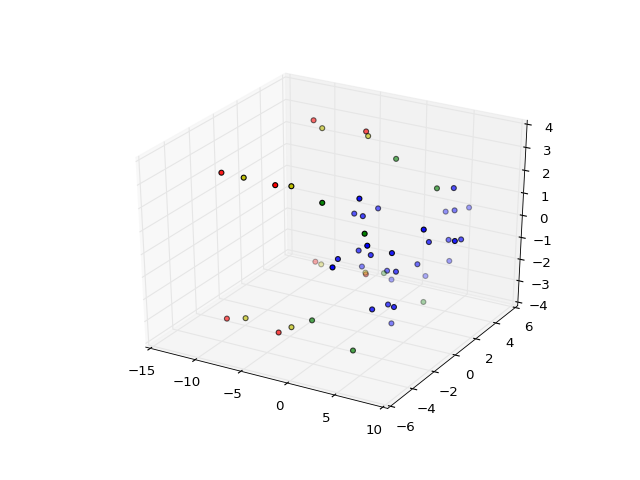

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XYZ[:,0], XYZ[:,1], XYZ[:,2])
#ax.scatter(k_nodo.obb[0][:,0],  k_nodo.obb[0][:,1], k_nodo.obb[0][:,2], c ='r')
ax.scatter(h_nodo.obb[0][:,0],  h_nodo.obb[0][:,1], h_nodo.obb[0][:,2], c ='r')
ax.scatter(f_nodo.obb[0][:,0],  f_nodo.obb[0][:,1], f_nodo.obb[0][:,2], c ='g')
ax.scatter(g_nodo.obb[0][:,0],  g_nodo.obb[0][:,1], g_nodo.obb[0][:,2], c ='y');